This project using LTSM Teras to predict the Google Price

# SET UP

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout,LSTM
from sklearn.preprocessing import MinMaxScaler
import math
from sklearn.metrics import mean_squared_error
from kerastuner.engine.hyperparameters import HyperParameters
from tensorflow import keras
from tensorflow.keras import layers
from kerastuner.tuners import RandomSearch

# Extract Data

kaggle data

https://www.kaggle.com/rahulsah06/gooogle-stock-price

In [61]:
df_train = pd.read_csv("./Google_Stock_Price_Train.csv",index_col='Date', parse_dates=['Date'])
df_train

,Open,High,Low,Close,Volume
Date,,,,,
2012-01-03,325.25,332.83,324.97,663.59,"7,380,500"
2012-01-04,331.27,333.87,329.08,666.45,"5,749,400"
2012-01-05,329.83,330.75,326.89,657.21,"6,590,300"
2012-01-06,328.34,328.77,323.68,648.24,"5,405,900"
2012-01-09,322.04,322.29,309.46,620.76,"11,688,800"
...,...,...,...,...,...
2016-12-23,790.90,792.74,787.28,789.91,"623,400"
2016-12-27,790.68,797.86,787.66,791.55,"789,100"
2016-12-28,793.70,794.23,783.20,785.05,"1,153,800"


In [62]:
df_test = pd.read_csv("./Google_Stock_Price_Test.csv",index_col='Date', parse_dates=['Date'])
df_test

,Open,High,Low,Close,Volume
Date,,,,,
2017-01-03,778.81,789.63,775.80,786.14,"1,657,300"
2017-01-04,788.36,791.34,783.16,786.90,"1,073,000"
2017-01-05,786.08,794.48,785.02,794.02,"1,335,200"
2017-01-06,795.26,807.90,792.20,806.15,"1,640,200"
2017-01-09,806.40,809.97,802.83,806.65,"1,272,400"
2017-01-10,807.86,809.13,803.51,804.79,"1,176,800"
2017-01-11,805.00,808.15,801.37,807.91,"1,065,900"
2017-01-12,807.14,807.39,799.17,806.36,"1,353,100"
2017-01-13,807.48,811.22,806.69,807.88,"1,099,200"


We will try to predict the Closing value in this project, and the same process can be applied to other columns.

# Preprocessing the data and  Visualize the Data

Since the csv file store the number using format '0,000.00' therefore if the number larger than or equal to 1000, the column would be identified as string, thus we need to preprocessing them.

In [72]:
closing_tr = df_train['Close'].apply(lambda x : x.replace(',', '')).astype('float')
closing_ts = df_test['Close']

In [73]:
closing_tr.head()

Date
2012-01-03    663.59
2012-01-04    666.45
2012-01-05    657.21
2012-01-06    648.24
2012-01-09    620.76
Name: Close, dtype: float64

In [74]:
closing_ts.head()

Date
2017-01-03    786.14
2017-01-04    786.90
2017-01-05    794.02
2017-01-06    806.15
2017-01-09    806.65
Name: Close, dtype: float64

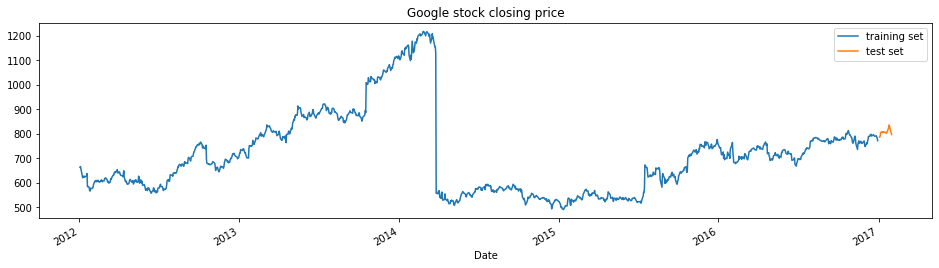

In [75]:
closing_tr.plot(figsize=(16,4),label="training set")
closing_ts.plot(figsize=(16,4),label="test set")
plt.legend()
plt.title("Google stock closing price")
plt.show()

## scaling the closing value and get the input
https://machinelearningmastery.com/how-to-improve-neural-network-stability-and-modeling-performance-with-data-scaling/ 


scaling the input and output variable can help to improve the stability and performance of the neural network.
unscaled input variables can cause slow and unstable leanring process.
unscaled output variables can cause the learning process to fail.

we use MinMaxScaler to standarlized all the columns to (0,1) according to the minimum and maximum values in the column.

https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html

In [264]:
sc = MinMaxScaler(feature_range=(0,1))

In [265]:
closing_total = pd.concat((closing_tr,closing_ts),axis=0)

In [266]:
closing_total

Date
2012-01-03    663.59
2012-01-04    666.45
2012-01-05    657.21
2012-01-06    648.24
2012-01-09    620.76
               ...  
2017-01-25    835.67
2017-01-26    832.15
2017-01-27    823.31
2017-01-30    802.32
2017-01-31    796.79
Name: Close, Length: 1278, dtype: float64

In [299]:
closing_total_scaled = sc.fit_transform(np.array(closing_total).reshape(-1,1))

In [300]:
closing_total_scaled

array([[0.23757287],
       [0.24151427],
       [0.22878051],
       ...,
       [0.45768505],
       [0.42875846],
       [0.42113749]])

In [301]:
train_len = len(closing_tr)
train_len

1258

In [303]:
def generate_dataset(df, timesteps,train_len):
    x_train, y_train, x_test, y_test = [], [], [], []
    for i in range(train_len-timesteps):
        x_train.append(df[i:i+timesteps,0])
        y_train.append(df[i+timesteps,0])
    for i in range(train_len-timesteps,len(df)-timesteps):
        x_test.append(df[i:i+timesteps,0])
        y_test.append(df[i+timesteps,0])
    return np.array(x_train), np.array(y_train), np.array(x_test), np.array(y_test)

In [304]:
x_train, y_train, x_test, y_test = generate_dataset(closing_total_scaled,30, train_len)

In [305]:
x_train[0]

array([0.23757287, 0.24151427, 0.22878051, 0.21641884, 0.1785483 ,
       0.17947163, 0.18335791, 0.18841558, 0.18202114, 0.18695478,
       0.19290823, 0.2020589 , 0.12842633, 0.12777862, 0.12146686,
       0.1057426 , 0.10382702, 0.12015766, 0.11701556, 0.12033681,
       0.12132905, 0.12721359, 0.14263468, 0.16016427, 0.15698083,
       0.16121164, 0.1634304 , 0.15579565, 0.16443642, 0.16108761])

In [306]:
y_train[0]

0.15531331394787973

## to make sure that we get the correct training and test dataset

In [274]:
len(closing_ts)

20

In [275]:
len(x_test)

20

In [307]:
x_train[0]

array([0.23757287, 0.24151427, 0.22878051, 0.21641884, 0.1785483 ,
       0.17947163, 0.18335791, 0.18841558, 0.18202114, 0.18695478,
       0.19290823, 0.2020589 , 0.12842633, 0.12777862, 0.12146686,
       0.1057426 , 0.10382702, 0.12015766, 0.11701556, 0.12033681,
       0.12132905, 0.12721359, 0.14263468, 0.16016427, 0.15698083,
       0.16121164, 0.1634304 , 0.15579565, 0.16443642, 0.16108761])

In [308]:
x_test[0]

array([0.38591293, 0.3711809 , 0.38311536, 0.38183372, 0.37180106,
       0.37275195, 0.38179237, 0.38537547, 0.36773562, 0.35378912,
       0.35734465, 0.37390957, 0.3692102 , 0.38585781, 0.39306534,
       0.41080165, 0.41077409, 0.4201866 , 0.42152337, 0.42259829,
       0.4128826 , 0.41756818, 0.42062759, 0.4180643 , 0.41351653,
       0.41165608, 0.41391618, 0.40495845, 0.40184391, 0.38672602])

In [309]:
y_test[-1]

0.4211374943152846

In [310]:
closing_total_scaled[-1]

array([0.42113749])

In [311]:
y_train[-1]

0.3867260173917837

## reshape the data so that can put into model as input

In [312]:
x_train.shape

(1228, 30)

In [313]:
x_train = x_train.reshape(x_train.shape[0],x_train.shape[1],1)

In [314]:
x_train.shape

(1228, 30, 1)

In [315]:
x_test = x_test.reshape(x_test.shape[0],x_test.shape[1],1)

In [324]:
x_test.shape

(20, 30, 1)

# Build the LSTM model

LSTM architecture explanation on Youtube <br>
https://www.youtube.com/watch?v=vTouAvxlphc

LSTM keras implementation with explanation on Youtube <br>
https://www.kaggle.com/pathanamjadkhan/lstm-tensor-kera-s-google-stock

kaggle code examples and tutorial <br>
https://www.kaggle.com/thebrownviking20/intro-to-recurrent-neural-networks-lstm-gru <br>
https://www.kaggle.com/pathanamjadkhan/lstm-tensor-kera-s-google-stock

return_state and return_sequences <br>
https://machinelearningmastery.com/return-sequences-and-return-states-for-lstms-in-keras/

In [317]:
def build_LSTM():
    model = Sequential()
    
    model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1],1)))
    model.add(LSTM(units=50, return_sequences=True))
    model.add(LSTM(units=50, return_sequences=True))
    model.add(LSTM(units=50))
    
    model.add(Dense(units=1))

    model.compile(optimizer='rmsprop',loss='mean_squared_error')
    
    return model

In [318]:
baseline_LSTM = build_LSTM()

In [319]:
baseline_LSTM.fit(x_train,y_train,epochs=50,batch_size=32)

Epoch 1/50
39/39 [==============================] - 6s 27ms/step - loss: 0.0291
Epoch 2/50
39/39 [==============================] - 1s 26ms/step - loss: 0.0132
Epoch 3/50
39/39 [==============================] - 1s 25ms/step - loss: 0.0104
Epoch 4/50
39/39 [==============================] - 1s 25ms/step - loss: 0.0080
Epoch 5/50
39/39 [==============================] - 1s 25ms/step - loss: 0.0066
Epoch 6/50
39/39 [==============================] - 1s 26ms/step - loss: 0.0056
Epoch 7/50
39/39 [==============================] - 1s 27ms/step - loss: 0.0052
Epoch 8/50
39/39 [==============================] - 1s 26ms/step - loss: 0.0044
Epoch 9/50
39/39 [==============================] - 1s 26ms/step - loss: 0.0042
Epoch 10/50
39/39 [==============================] - 1s 25ms/step - loss: 0.0035
Epoch 11/50
39/39 [==============================] - 1s 27ms/step - loss: 0.0030
Epoch 12/50
39/39 [==============================] - 1s 26ms/step - loss: 0.0031
Epoch 13/50
39/39 [==================

In [320]:
y_predicted = baseline_LSTM.predict(x_test)

In [326]:
y_test

array([0.40646059, 0.40750796, 0.41732012, 0.43403663, 0.43472569,
       0.4321624 , 0.43646211, 0.43432603, 0.43642077, 0.43191434,
       0.43392638, 0.42855174, 0.43247936, 0.45217259, 0.45845679,
       0.47471852, 0.46986756, 0.45768505, 0.42875846, 0.42113749])

In [327]:
y_predicted

array([[0.42382884],
       [0.43996778],
       [0.44404188],
       [0.4541375 ],
       [0.4718344 ],
       [0.47524184],
       [0.47304165],
       [0.47665018],
       [0.47492775],
       [0.4766374 ],
       [0.47236672],
       [0.47368732],
       [0.4685927 ],
       [0.47172615],
       [0.49155167],
       [0.500609  ],
       [0.51811445],
       [0.5151288 ],
       [0.5023452 ],
       [0.47181395]], dtype=float32)

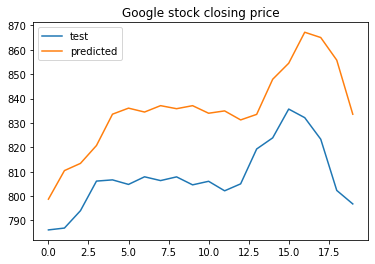

In [325]:
plt.plot(sc.inverse_transform(y_test.reshape(-1,1)),label="test")
plt.plot(sc.inverse_transform(y_predicted), label = "predicted")
plt.legend()
plt.title("Google stock closing price")
plt.show()

The graph shows that we can correctly predict the trend of the stock price.